In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from keras.layers import Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import time

In [2]:
# 2. Load data
train_dir = "../input/gender-dataset/Dataset/Validation/"
test_dir = "../input/gender-dataset/Dataset/Test/"

CATEGORIES = {
    0: "FeMale",
    1: "Male"
}

img_width = 64
img_height = 64
img_channel = 3

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height),
                                                     subset='training', class_mode='binary')
val_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height), 
                                                   subset='validation', class_mode='binary')
test_generator = data_generator.flow_from_directory(test_dir, target_size=(img_width, img_height), 
                                                    class_mode='binary')

Found 18079 images belonging to 2 classes.
Found 4519 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


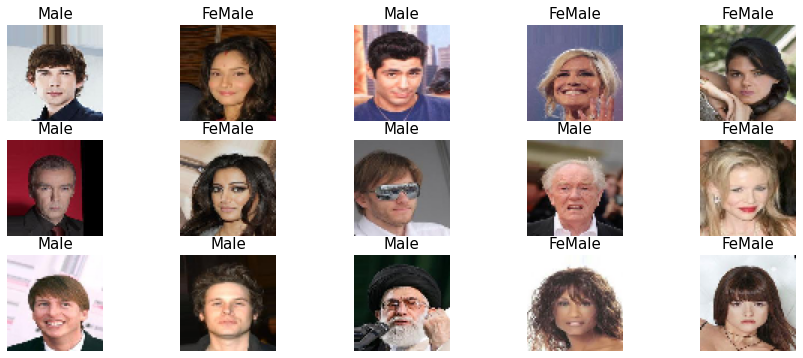

In [3]:
# 3. Show image
img, label = val_generator.next()
rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[label[i]], fontsize=15)

In [4]:
# 4. Build model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, img_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2022-07-20 11:09:44.397378: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In [5]:
# 5. Train model
start_time = time.time()

numOfEpoch = 10
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2,
                                            verbose = 1, factor = 0.5, min_lr = 0.00001)

H =  model.fit(train_generator, epochs = numOfEpoch, validation_data = val_generator, 
               verbose=1, callbacks=[earlystop,learning_rate_reduction])

end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

2022-07-20 11:09:44.945277: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
565/565 [==============================] - 144s 253ms/step - loss: 0.3408 - accuracy: 0.8504 - val_loss: 0.1797 - val_accuracy: 0.9292
Epoch 2/10
565/565 [==============================] - 121s 215ms/step - loss: 0.1634 - accuracy: 0.9337 - val_loss: 0.1331 - val_accuracy: 0.9440
Epoch 3/10
565/565 [==============================] - 122s 216ms/step - loss: 0.1307 - accuracy: 0.9466 - val_loss: 0.1111 - val_accuracy: 0.9535
Epoch 4/10
565/565 [==============================] - 122s 216ms/step - loss: 0.1118 - accuracy: 0.9556 - val_loss: 0.1010 - val_accuracy: 0.9608
Epoch 5/10
565/565 [==============================] - 122s 216ms/step - loss: 0.0964 - accuracy: 0.9622 - val_loss: 0.1199 - val_accuracy: 0.9509
Epoch 6/10
565/565 [==============================] - 121s 215ms/step - loss: 0.0888 - accuracy: 0.9651 - val_loss: 0.0996 - val_accuracy: 0.9617
Epoch 7/10
565/565 [==============================] - 124s 219ms/step - loss: 0.0822 - accuracy: 0.9680 - val_loss: 0.0970 -

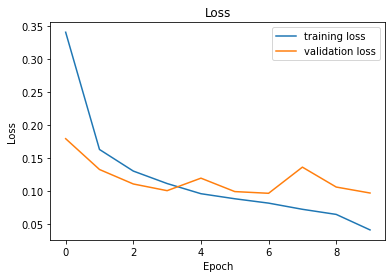

In [6]:
# 6. Vẽ đồ thị loss của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['loss'], label='training loss')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

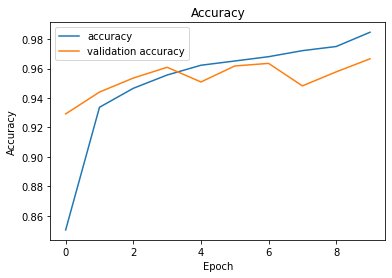

In [7]:
# 7. Vẽ đồ thị accuracy của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
# 8. Đánh giá model với testset
start_time = time.time()
print('[loss, accuracy]: ', model.evaluate(test_generator, verbose = 1))
end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

626/626 [==============================] - 88s 141ms/step - loss: 0.0914 - accuracy: 0.9688
[loss, accuracy]:  [0.09135228395462036, 0.9687515497207642]
Running time: 88.33 (s)


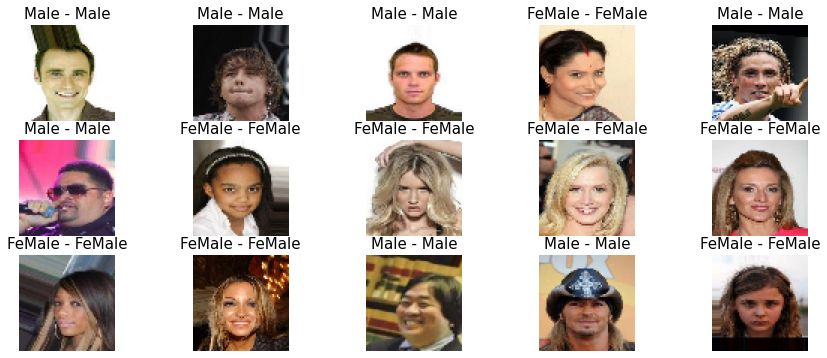

In [9]:
# 9. Show predict on tesetset
img, label = test_generator.next()
rows = 3
cols = 5

y_pred = model.predict(img[0: rows * cols])

fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    if y_pred[i] > 0.5 : y = 1
    else: y = 0
    axes[i].set_title(CATEGORIES[y] + ' - ' + CATEGORIES[label[i]], fontsize=15)

In [10]:
# 10. Save model
model.save("Gender_Classification_Model.h5")